In [56]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import gzip
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import random
import os
import io
import trimesh
from scipy.sparse import coo_matrix
import open3d as o3d
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torch.optim as optim


In [57]:
class MCGillDataset(Dataset):
    def __init__(self, root_dir: str, transform=None):
        """
        Custom dataset.
        Parameters:
        - root_dir (str): Root directory of the dataset.
        - transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform

        # List all the categories (subdirectories) in the root directory
        self.categories = os.listdir(root_dir)

        # Create a dictionary to map category names to their respective subdirectories
        self.category_paths = {category: os.path.join(root_dir, category) for category in self.categories}

        self.all_data_paths = self.get_all_data_paths()
        self.look_up_table = self.get_look_up_table()

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.all_data_paths)

    def __getitem__(self, idx):
        """
        Returns a sample from the dataset.

        Parameters:
        - idx (int): Index of the sample.

        Returns:
        - sample (dict): A dictionary containing 'data' (3D mesh) and 'label' (category name).
        """
        # Load the data (3D mesh) using the appropriate method
        data_path = self.all_data_paths[idx]
        category = self.get_category_from_path(data_path)
        image = Image.open(data_path)  # Directly open PNG image

        # Retrieve the value from the lookup table
        value = self.look_up_table.get(category, None)
        # Apply the optional transform
        if self.transform:
            image = self.transform(image)

        # Load the data (3D mesh) using the appropriate method
        data_path_3d = self.get_path_to_model(self.all_data_paths[idx])
        category = self.get_category_from_path(data_path_3d)

        if data_path_3d.endswith('.gz'):
            with gzip.open(data_path_3d, 'rb') as f:
                file_extension = os.path.splitext(data_path_3d[:-3])[1]
                data = trimesh.load(file_obj=io.BytesIO(f.read()), file_type=file_extension, process=False)
        else:
            file_extension = os.path.splitext(data_path_3d)[1]
            data = trimesh.load(data_path_3d, file_type=file_extension, process=False)

        # Convert mesh to point cloud
        pcd = self.ply_to_pcd(data)

        # Prepare the sample dictionary
        sample = {'image': image, 'label': category, 'value': value, 'path_image': data_path, 'pcd': np.array(pcd.points), 'path_to_3d': data_path_3d}

        return sample

    def get_category_from_path(self, data_path):
        """
        Extract category name from the data path.

        Parameters:
        - data_path (str): Full path to the data file.

        Returns:
        - category (str): Category name.
        """
        # Extract category name from the path
        category = os.path.basename(os.path.dirname(os.path.dirname(data_path)))
        return category


    def get_all_data_paths(self):
        """
        Return a list of all data paths in the dataset.
        """
        all_paths = []
        for category in self.categories:
            category_path = self.category_paths[category]
            model_names = os.listdir(category_path)
            for model in model_names:
                data_paths = os.listdir(os.path.join(category_path, model))
                full_paths = [os.path.join(category_path, model, data_name) for data_name in data_paths]
                all_paths.extend(full_paths)
        return all_paths
    
    def get_look_up_table(self):
        labels = set()
        for category in self.categories:
            labels.add(category)
        lookup_table = {}
        for i, label in enumerate(labels):
            lookup_table[label] = i
        return lookup_table

    def get_photo(self, idx):
        return self.__getitem__(idx)['image']

    def get_path_to_model(self, current_path):

        # Split the path to get individual components
        parts = current_path.split('/')
        parts = parts[2].split(os.sep)

        # Extract label and model from the path
        label = parts[0]  
        model_with_extra = parts[1]  
        model = model_with_extra.split('\\')[0]  

        # Assemble the new path
        new_path = os.path.join('.', 'articulated', label, f'{label}Ply', f'{model}')


        return new_path

    def ply_to_pcd(self, mesh):
        # Check if the mesh is a valid trimesh object
        if not isinstance(mesh, trimesh.Trimesh):
            raise TypeError("The input is not a trimesh.Trimesh object.")

        # Extract vertices from the mesh to form a point cloud
        pcd = o3d.geometry.PointCloud()
        vertices = np.asarray(mesh.vertices)

        # Normalize the point cloud
        centroid = np.mean(vertices, axis=0)
        vertices -= centroid
        furthest_distance = np.max(np.sqrt(np.sum(vertices ** 2, axis=1)))
        vertices /= furthest_distance

        pcd.points = o3d.utility.Vector3dVector(vertices)

        # Check if the mesh has vertex colors
        if hasattr(mesh.visual, 'vertex_colors') and mesh.visual.vertex_colors is not None:
            # Normalize the colors and add them to the point cloud
            pcd.colors = o3d.utility.Vector3dVector(mesh.visual.vertex_colors[:, :3] / 255.0)

        return pcd

In [58]:
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])
#Transform to Tensor and resize for faster computational time
root_dir = './2dImages/'
dataset = MCGillDataset(root_dir=root_dir, transform=transform)

In [59]:
dataset[0]

{'image': tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 'label': 'humans',
 'value': 0,
 'path_image': './2dImages/humans\\b21.ply\\b21.ply_00.png',
 'pcd': array([[-0.09164612, -0.13346054, -0.15313565],
        [-0.07382972, -0.133460

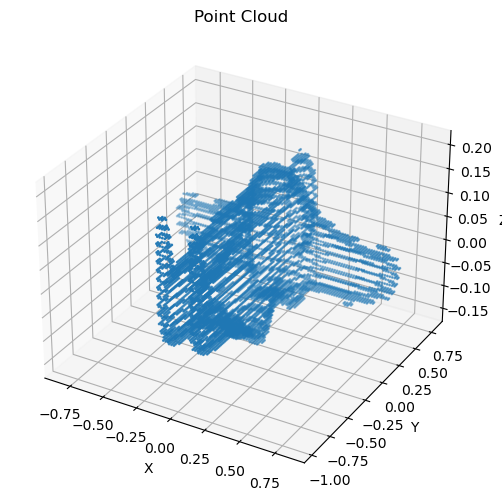

In [60]:
data = dataset[0]['pcd']

def plot_point_cloud(data, title="Point Cloud"):
    """
    Plot a 3D point cloud.

    Parameters:
    - data (numpy.ndarray): The point cloud data, an Nx3 array of X, Y, Z coordinates.
    - title (str, optional): The title of the plot.
    - point_size (int, optional): The size of the points in the plot.
    """
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], s=1)
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

# Example usage
plot_point_cloud(data)

In [61]:
batch_size = 1


# Determine the lengths for train and validation sets
train_size = int(0.8 * len(dataset))
validation_size = len(dataset) - train_size

# Randomly split the dataset
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

# Create data loaders (optional, if you want to load data in batches)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size = batch_size, shuffle=False)

In [62]:
import pickle
with open('info_ellipsoid.dat', "rb") as fp:
        fp_info = pickle.load(fp, encoding = 'latin1')
            # shape: n_pts * 3
        init_coord = fp_info[0]

        # edges & faces & lap_idx
        # edge: num_edges * 2
        # faces: num_faces * 4
        # lap_idx: num_pts * 10
        edges, faces, lap_idx = [], [], []

        for i in range(3):
            edges.append(fp_info[1 + i][1][0])
            faces.append(fp_info[5][i])
            lap_idx.append(fp_info[7][i])

        # pool index
        # num_pool_edges * 2
        pool_idx = [fp_info[4][0], fp_info[4][1]] # pool_01: 462 * 2, pool_12: 1848 * 2

        # supports
        # 0: np.array, 2D, pos
        # 1: np.array, 1D, vals
        # 2: tuple - shape, n * n
        support1, support2, support3 = [], [], []

        for i in range(2):
            support1.append(fp_info[1][i])
            support2.append(fp_info[2][i])
            support3.append(fp_info[3][i])
            
        keys = ["coord", "edges", "faces", "lap_idx", "pool_idx", "supports"]
        vals = [init_coord, edges, faces, lap_idx, pool_idx, [support1, support2, support3]]

        ellipsoid = dict(zip(keys, vals))


In [63]:
ellipsoid["coord"]

array([[-0.1475  , -0.1475  , -0.876884],
       [-0.1475  , -0.161837, -0.845   ],
       [-0.176174, -0.1475  , -0.845   ],
       [-0.1475  , -0.164438, -0.7675  ],
       [-0.181376, -0.1475  , -0.7675  ],
       [-0.1475  , -0.1475  , -0.723224],
       [-0.07    , -0.1475  , -0.924942],
       [-0.07    , -0.149614, -0.9225  ],
       [-0.077241, -0.1475  , -0.9225  ],
       [-0.07    , -0.184463, -0.845   ],
       [-0.07    , -0.187064, -0.7675  ],
       [-0.103966, -0.1475  , -0.69    ],
       [-0.07    , -0.157416, -0.69    ],
       [-0.07    , -0.1475  , -0.677584],
       [ 0.0075  , -0.1475  , -0.932452],
       [ 0.0075  , -0.156116, -0.9225  ],
       [ 0.0075  , -0.190965, -0.845   ],
       [ 0.0075  , -0.193565, -0.7675  ],
       [ 0.0075  , -0.163918, -0.69    ],
       [ 0.0075  , -0.1475  , -0.669443],
       [ 0.076892, -0.1475  , -0.9225  ],
       [ 0.085   , -0.1475  , -0.920261],
       [ 0.085   , -0.181342, -0.845   ],
       [ 0.085   , -0.183943, -0.7

In [64]:
def torch_sparse_tensor(indice, value, size, use_cuda):

    coo = coo_matrix((value, (indice[:, 0], indice[:, 1])), shape = size)
    values = coo.data
    indices = np.vstack((coo.row, coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = coo.shape

    if use_cuda:
        return torch.sparse.FloatTensor(i, v, shape).cuda()
    else:
        return torch.sparse.FloatTensor(i, v, shape)


def dot(x, y, sparse = False):
    """Wrapper for torch.matmul (sparse vs dense)."""
    if sparse:
        res = x.mm(y)
    else:
        res = torch.matmul(x, y)
    return res


class GraphConvolution(Module):
    """Simple GCN layer
    Similar to https://arxiv.org/abs/1609.02907
    """
    def __init__(self, in_features, out_features, adjs, bias=True, use_cuda = True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        adj0 = torch_sparse_tensor(*adjs[0], use_cuda)
        adj1 = torch_sparse_tensor(*adjs[1], use_cuda)
        self.adjs = [adj0, adj1]

        self.weight_1 = Parameter(torch.FloatTensor(in_features, out_features))
        self.weight_2 = Parameter(torch.FloatTensor(in_features, out_features))

        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight_1.size(1))
        self.weight_1.data.uniform_(-stdv, stdv)
        self.weight_2.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        support_1 = torch.matmul(input, self.weight_1)
        support_2 = torch.matmul(input, self.weight_2)
        #output = torch.spmm(adj, support)
        output1 = dot(self.adjs[0], support_1, True)
        output2 = dot(self.adjs[1], support_2, True)
        output = output1 + output2
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
            + str(self.in_features) + ' -> ' \
            + str(self.out_features) + ')'


class GraphPooling(Module):
    """Graph Pooling layer, aims to add additional vertices to the graph.

    The middle point of each edges are added, and its feature is simply
    the average of the two edge vertices.
    Three middle points are connected in each triangle.
    """

    def __init__(self, pool_idx):
        super(GraphPooling, self).__init__() 
        self.pool_idx = pool_idx
        # save dim info
        self.in_num = np.max(pool_idx)
        self.out_num = self.in_num + len(pool_idx)

    def forward(self, input):

        new_features = input[self.pool_idx].clone()
        new_vertices = 0.5 * new_features.sum(1)
        output = torch.cat((input, new_vertices), 0)

        return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_num) + ' -> ' \
               + str(self.out_num) + ')'



class GraphProjection(Module):
    """Graph Projection layer, which pool 2D features to mesh

    The layer projects a vertex of the mesh to the 2D image and use 
    bilinear interpolation to get the corresponding feature.
    """

    def __init__(self):
        super(GraphProjection, self).__init__()


    def forward(self, img_features, input):

        self.img_feats = img_features 

        h = 248 * torch.div(input[:, 1], input[:, 2]) + 111.5
        w = 248 * torch.div(input[:, 0], -input[:, 2]) + 111.5

        h = torch.clamp(h, min = 0, max = 223)
        w = torch.clamp(w, min = 0, max = 223)

        img_sizes = [56, 28, 14, 7]
        out_dims = [64, 128, 256, 512]
        feats = [input]

        for i in range(4):
            out = self.project(i, h, w, img_sizes[i], out_dims[i])
            feats.append(out)
            
        output = torch.cat(feats, 1)
        
        return output

    def project(self, index, h, w, img_size, out_dim):

        img_feat = self.img_feats[index]
        x = h / (224. / img_size)
        y = w / (224. / img_size)

        x1, x2 = torch.floor(x).long(), torch.ceil(x).long()
        y1, y2 = torch.floor(y).long(), torch.ceil(y).long()

        x2 = torch.clamp(x2, max = img_size - 1)
        y2 = torch.clamp(y2, max = img_size - 1)

        #Q11 = torch.index_select(torch.index_select(img_feat, 1, x1), 1, y1)
        #Q12 = torch.index_select(torch.index_select(img_feat, 1, x1), 1, y2)
        #Q21 = torch.index_select(torch.index_select(img_feat, 1, x2), 1, y1)
        #Q22 = torch.index_select(torch.index_select(img_feat, 1, x2), 1, y2)

        Q11 = img_feat[:, x1, y1].clone()
        Q12 = img_feat[:, x1, y2].clone()
        Q21 = img_feat[:, x2, y1].clone()
        Q22 = img_feat[:, x2, y2].clone()

        x, y = x.long(), y.long()

        weights = torch.mul(x2 - x, y2 - y)
        Q11 = torch.mul(weights.float().view(-1, 1), torch.transpose(Q11, 0, 1))

        weights = torch.mul(x2 - x, y - y1)
        Q12 = torch.mul(weights.float().view(-1, 1), torch.transpose(Q12, 0 ,1))

        weights = torch.mul(x - x1, y2 - y)
        Q21 = torch.mul(weights.float().view(-1, 1), torch.transpose(Q21, 0, 1))

        weights = torch.mul(x - x1, y - y1)
        Q22 = torch.mul(weights.float().view(-1, 1), torch.transpose(Q22, 0, 1))

        output = Q11 + Q21 + Q12 + Q22

        return output

In [65]:
class P2M_Model(nn.Module):
    """
    Implement the joint model for Pixel2mesh
    """

    def __init__(self, features_dim, hidden_dim, coord_dim, pool_idx, supports, use_cuda):

        super(P2M_Model, self).__init__()
        self.img_size = 224

        self.features_dim = features_dim
        self.hidden_dim = hidden_dim
        self.coord_dim = coord_dim
        self.pool_idx = pool_idx
        self.supports = supports
        self.use_cuda = use_cuda

        self.build()


    def build(self):

        self.nn_encoder = self.build_encoder()
        self.nn_decoder = self.build_decoder()

        self.GCN_0 = GBottleneck(6, self.features_dim, self.hidden_dim, self.coord_dim, self.supports[0], self.use_cuda)
        self.GCN_1 = GBottleneck(6, self.features_dim + self.hidden_dim, self.hidden_dim, self.coord_dim, self.supports[1], self.use_cuda)
        self.GCN_2 = GBottleneck(6, self.features_dim + self.hidden_dim, self.hidden_dim, self.hidden_dim, self.supports[2], self.use_cuda)

        self.GPL_1 = GraphPooling(self.pool_idx[0])
        self.GPL_2 = GraphPooling(self.pool_idx[1])

        self.GPR_0 = GraphProjection() 
        self.GPR_1 = GraphProjection()
        self.GPR_2 = GraphProjection()

        self.GConv = GraphConvolution(in_features = self.hidden_dim, out_features = self.coord_dim, adjs = self.supports[2], use_cuda = self.use_cuda)

        self.GPL_12 = GraphPooling(self.pool_idx[0])
        self.GPL_22 = GraphPooling(self.pool_idx[1])


    def forward(self, img, input):

        img_feats = self.nn_encoder(img)

        # GCN Block 1
        x = self.GPR_0(img_feats, input)
        x1, x_cat = self.GCN_0(x)
        x1_2 = self.GPL_12(x1)

        # GCN Block 2
        x = self.GPR_1(img_feats, x1)
        x = torch.cat([x, x_cat], 1)
        x = self.GPL_1(x)
        x2, x_cat = self.GCN_1(x)
        x2_2 = self.GPL_22(x2)
        
        # GCN Block 3
        x = self.GPR_2(img_feats, x2)
        x = torch.cat([x, x_cat], 1)
        x = self.GPL_2(x)
        x, _ = self.GCN_2(x)

        x3 = self.GConv(x)

        new_img = self.nn_decoder(img_feats)

        return [x1, x2, x3], [input, x1_2, x2_2], new_img


    def build_encoder(self):
        # VGG16 at first, then try resnet
        # Can load params from model zoo
        net = VGG16_Pixel2Mesh(n_classes_input = 3)
        return net

    def build_decoder(self):
        net = VGG16_Decoder()
        return net


class GResBlock(nn.Module):

    def __init__(self, in_dim, hidden_dim, adjs, use_cuda):
        super(GResBlock, self).__init__()

        self.conv1 = GraphConvolution(in_features = in_dim, out_features = hidden_dim, adjs = adjs, use_cuda = use_cuda)
        self.conv2 = GraphConvolution(in_features = in_dim, out_features = hidden_dim, adjs = adjs, use_cuda = use_cuda) 


    def forward(self, input):
        
        x = self.conv1(input)
        x = self.conv2(x)

        return (input + x) * 0.5


class GBottleneck(nn.Module):

    def __init__(self, block_num, in_dim, hidden_dim, out_dim, adjs, use_cuda):
        super(GBottleneck, self).__init__()

        blocks = [GResBlock(in_dim = hidden_dim, hidden_dim = hidden_dim, adjs = adjs, use_cuda = use_cuda)]

        for _ in range(block_num - 1):
            blocks.append(GResBlock(in_dim = hidden_dim, hidden_dim = hidden_dim, adjs = adjs, use_cuda = use_cuda))

        self.blocks = nn.Sequential(*blocks)
        self.conv1 = GraphConvolution(in_features = in_dim, out_features = hidden_dim, adjs = adjs, use_cuda = use_cuda)
        self.conv2 = GraphConvolution(in_features = hidden_dim, out_features = out_dim, adjs = adjs, use_cuda = use_cuda)

        
    def forward(self, input):

        x = self.conv1(input)
        x_cat = self.blocks(x)
        x_out = self.conv2(x_cat)

        return x_out, x_cat
    
    
class VGG16_Pixel2Mesh(nn.Module):
    
    def __init__(self, n_classes_input = 3):
        
        super(VGG16_Pixel2Mesh, self).__init__()

        self.conv0_1 = nn.Conv2d(n_classes_input, 16, 3, stride = 1, padding = 1)
        self.conv0_2 = nn.Conv2d(16, 16, 3, stride = 1, padding = 1)
        
        self.conv1_1 = nn.Conv2d(16, 32, 3, stride = 2, padding = 1) # 224 -> 112
        self.conv1_2 = nn.Conv2d(32, 32, 3, stride = 1, padding = 1)
        self.conv1_3 = nn.Conv2d(32, 32, 3, stride = 1, padding = 1)
        
        self.conv2_1 = nn.Conv2d(32, 64, 3, stride = 2, padding = 1) # 112 -> 56
        self.conv2_2 = nn.Conv2d(64, 64, 3, stride = 1, padding = 1)
        self.conv2_3 = nn.Conv2d(64, 64, 3, stride = 1, padding = 1)
        
        self.conv3_1 = nn.Conv2d(64, 128, 3, stride = 2, padding = 1) # 56 -> 28
        self.conv3_2 = nn.Conv2d(128, 128, 3, stride = 1, padding = 1)
        self.conv3_3 = nn.Conv2d(128, 128, 3, stride = 1, padding = 1)
        
        self.conv4_1 = nn.Conv2d(128, 256, 5, stride = 2, padding = 2) # 28 -> 14
        self.conv4_2 = nn.Conv2d(256, 256, 3, stride = 1, padding = 1)
        self.conv4_3 = nn.Conv2d(256, 256, 3, stride = 1, padding = 1)
        
        self.conv5_1 = nn.Conv2d(256, 512, 5, stride = 2, padding = 2) # 14 -> 7
        self.conv5_2 = nn.Conv2d(512, 512, 3, stride = 1, padding = 1)
        self.conv5_3 = nn.Conv2d(512, 512, 3, stride = 1, padding = 1)
        self.conv5_4 = nn.Conv2d(512, 512, 3, stride = 1, padding = 1)
        
    def forward(self, img):
        
        img = F.relu(self.conv0_1(img))
        img = F.relu(self.conv0_2(img))
        #img0 = torch.squeeze(img) # 224
        
        img = F.relu(self.conv1_1(img))
        img = F.relu(self.conv1_2(img))
        img = F.relu(self.conv1_3(img))
        #img1 = torch.squeeze(img) # 112 
        
        img = F.relu(self.conv2_1(img))
        img = F.relu(self.conv2_2(img))
        img = F.relu(self.conv2_3(img))
        img2 = torch.squeeze(img) # 56
        
        img = F.relu(self.conv3_1(img))
        img = F.relu(self.conv3_2(img))
        img = F.relu(self.conv3_3(img))
        img3 = torch.squeeze(img) # 28
        
        img = F.relu(self.conv4_1(img))
        img = F.relu(self.conv4_2(img))
        img = F.relu(self.conv4_3(img))
        img4 = torch.squeeze(img) # 14
        
        img = F.relu(self.conv5_1(img))
        img = F.relu(self.conv5_2(img))
        img = F.relu(self.conv5_3(img))
        img = F.relu(self.conv5_4(img))
        img5 = torch.squeeze(img) #7
        
        return [img2, img3, img4, img5]


class VGG16_Decoder(nn.Module):

    def __init__(self, input_dim = 512, image_channel = 3):

        super(VGG16_Decoder, self).__init__()

        self.conv_1 = nn.ConvTranspose2d(input_dim, 256, kernel_size = 2, stride = 2, padding = 0) # 7 -> 14
        self.conv_2 = nn.ConvTranspose2d(512, 128, kernel_size = 4, stride = 2, padding = 1) # 14 -> 28
        self.conv_3 = nn.ConvTranspose2d(256, 64, kernel_size = 4, stride = 2, padding = 1)  # 28 -> 56
        self.conv_4 = nn.ConvTranspose2d(128, 32, kernel_size = 6, stride = 2, padding = 2)   # 56 -> 112
        self.conv_5 = nn.ConvTranspose2d(32, image_channel, kernel_size = 6, stride = 2, padding = 2) # 112 -> 224


    def forward(self, img_feats):

        x = F.relu(self.conv_1(img_feats[-1].unsqueeze(0)))
        x = torch.cat((x, img_feats[-2].unsqueeze(0)), dim = 1)
        x = F.relu(self.conv_2(x))
        x = torch.cat((x, img_feats[-3].unsqueeze(0)), dim = 1)
        x = F.relu(self.conv_3(x))
        x = torch.cat((x, img_feats[-4].unsqueeze(0)), dim = 1)
        x = F.relu(self.conv_4(x))
        x = F.relu(self.conv_5(x))

        return torch.sigmoid(x)

In [66]:
# Check Device (CPU / GPU)
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [67]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('GraphConv') != -1:
        m.reset_parameters()

In [68]:
# Create Network
network = P2M_Model(963, 192, 3, ellipsoid['pool_idx'], ellipsoid['supports'], use_cuda)
network.apply(weights_init) #initialization of the weight

P2M_Model(
  (nn_encoder): VGG16_Pixel2Mesh(
    (conv0_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv0_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv1_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_1): Conv2d(128, 256, kernel_size=(5, 5), stride=(

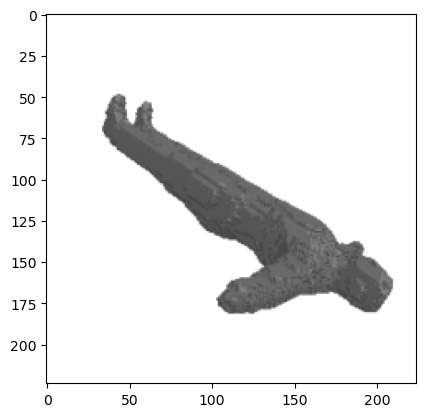

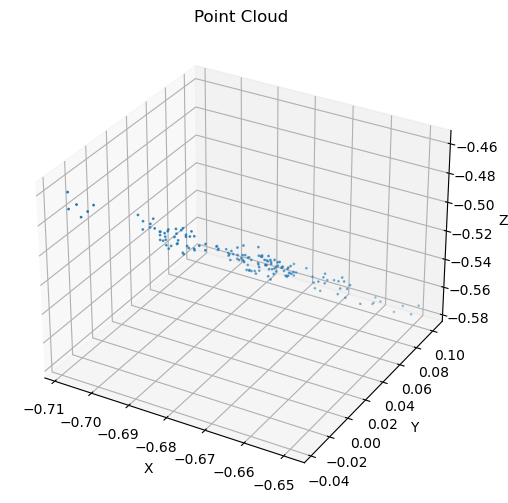

In [69]:
# Get a batch of training data
dataiter = iter(train_loader)
data = next(dataiter)

# print(data)
image,pcd = data['image'],data['pcd']
init_pcd = torch.from_numpy(ellipsoid['coord'])

pred_pts_list, pred_feats_list, pred_img = network(image, init_pcd)
# Test run on the model
plt.imshow(image[0].permute(1, 2, 0).numpy())
plot_point_cloud(pred_pts_list[0].detach().numpy())

In [70]:
print(ellipsoid["lap_idx"][2])

[[ 618  619  657 ...   -1    0    7]
 [ 621  622  627 ...   -1    1    7]
 [ 624  625  636 ...   -1    2    5]
 ...
 [ 559  617 2204 ...   -1 2463    6]
 [ 612  617 2433 ...   -1 2464    6]
 [ 559  612 2200 ...   -1 2465    6]]


In [71]:
#Define Losses
def chamfer_distance(set1, set2):
    """
    Compute the Chamfer Distance between two sets of points represented as tensors.

    Parameters:
    - set1 (torch.Tensor): A tensor of points (N, D) where N is the number of points in set1 and D is the dimension.
    - set2 (torch.Tensor): A tensor of points (M, D) where M is the number of points in set2 and D is the dimension.

    Returns:
    - float: The Chamfer Distance between the two sets.
    """
    N, _ = set1.size()
    M, _ = set2.size()

    # Expand set1 to (N, M, D)
    set1_expanded = set1.unsqueeze(1).expand(N, M, -1)
    # Expand set2 to (N, M, D)
    set2_expanded = set2.unsqueeze(0).expand(N, M, -1)

    # Compute the squared distances (N, M)
    distances = torch.sum((set1_expanded - set2_expanded) ** 2, dim=2)

    # Compute the minimum distance for each point in set1 to set2
    min_dist_set1_to_set2 = torch.min(distances, dim=1)[0]

    # Compute the minimum distance for each point in set2 to set1
    min_dist_set2_to_set1 = torch.min(distances, dim=0)[0]

    # Compute the Chamfer Distance
    chamfer_dist = torch.mean(min_dist_set1_to_set2) + torch.mean(min_dist_set2_to_set1)

    return chamfer_dist

def laplace_coord(input, lap_idx, block_id, use_cuda = True):
    
    # Inputs :
    # input : nodes Tensor, size (n_pts, n_features)
    # lap_idx : laplace index matrix Tensor, size (n_pts, 10)
    # 
    # Returns : 
    # The laplacian coordinates of input with respect to edges as in lap_idx

    
    vertex = torch.cat((input, torch.zeros(1, 3).cuda()), 0) if use_cuda else torch.cat((input, torch.zeros(1, 3)), 0)
    
    indices = torch.tensor(lap_idx[block_id][:, :3])
    weights = torch.tensor(lap_idx[block_id][:,-1], dtype = torch.float32)

    if use_cuda:
        indices = indices.cuda()
        weights = weights.cuda()

    weights = torch.reciprocal(weights).reshape((-1, 1)).repeat((1, 3))

    num_pts, num_indices = indices.shape[0], indices.shape[1]
    indices = indices.reshape((-1,))
    vertices = torch.index_select(vertex, 0, indices)
    vertices = vertices.reshape((num_pts, num_indices, 3))

    laplace = torch.sum(vertices, 1)
    laplace = input - torch.mul(laplace, weights)
        
    return laplace

def laplace_loss(input1, input2, lap_idx, block_id, use_cuda = True):

    # Inputs : 
    # input1, input2 : nodes Tensor before and after the deformation
    # lap_idx : laplace index matrix Tensor, size (n_pts, 10)
    # block_id : id of the deformation block (if different than 1 then adds
    # a move loss as in the original TF code)
    #
    # Returns :
    # The Laplacian loss, with the move loss as an additional term when relevant

    lap1 = laplace_coord(input1, lap_idx, block_id, use_cuda)
    lap2 = laplace_coord(input2, lap_idx, block_id, use_cuda)
    laplace_loss = torch.mean(torch.sum(torch.pow(lap1 - lap2, 2), 1)) * 1500
    move_loss = torch.mean(torch.sum(torch.pow(input1 - input2, 2), 1)) * 100

    if block_id == 0:
        return laplace_loss
    else:
        return laplace_loss + move_loss



def edge_loss(pred, gt_pts, edges, block_id, use_cuda = True):

	# edge in graph
    #nod1 = pred[edges[block_id][:, 0]]
    #nod2 = pred[edges[block_id][:, 1]]
    idx1 = torch.tensor(edges[block_id][:, 0]).long()
    idx2 = torch.tensor(edges[block_id][:, 1]).long()

    if use_cuda:
        idx1 = idx1.cuda()
        idx2 = idx2.cuda()

    nod1 = torch.index_select(pred, 0, idx1)
    nod2 = torch.index_select(pred, 0, idx2)
    edge = nod1 - nod2

	# edge length loss
    edge_length = torch.sum(torch.pow(edge, 2), 1)
    edge_loss = torch.mean(edge_length) * 300

    return edge_loss


def L1Tensor(img1, img2) : 
	""" input shoudl be tensor and between 0 and 1"""
	mae = torch.mean(torch.abs(img2 - img1))
	return mae


def L2Tensor(img1, img2) : 
	""" input shoudl be tensor and between 0 and 1"""
	mse = torch.mean((img2 - img1) ** 2)
	return mse

def total_pts_loss(pred_pts_list, pred_feats_list, gt_pts, ellipsoid, use_cuda = True):
    """
    pred_pts_list: [x1, x1_2, x2, x2_2, x3]
    """

    my_chamfer_loss, my_edge_loss, my_lap_loss = 0., 0., 0.
    lap_const = [0.2, 1., 1.]
    for i in range(3):
        my_chamfer_loss += chamfer_distance(pred_pts_list[i], gt_pts)
        my_edge_loss += edge_loss(pred_pts_list[i], gt_pts, ellipsoid["edges"], i, use_cuda)
        my_lap_loss += lap_const[i] * laplace_loss(pred_feats_list[i], pred_pts_list[i], ellipsoid["lap_idx"], i, use_cuda)

    my_pts_loss = 100 * my_chamfer_loss + 0.1 * my_edge_loss + 0.3 * my_lap_loss

    return my_pts_loss



def total_img_loss(pred_img, gt_img):

    my_rect_loss = torch.nn.functional.binary_cross_entropy(pred_img, gt_img, size_average = False)
    my_l1_loss = L1Tensor(pred_img, gt_img)

    img_loss = my_rect_loss + my_l1_loss

    return img_loss
    

In [72]:
optimizer = optim.Adam(network.parameters(), lr = 5e-5)

Epoch: 0


Total loss: 3109.0712890625


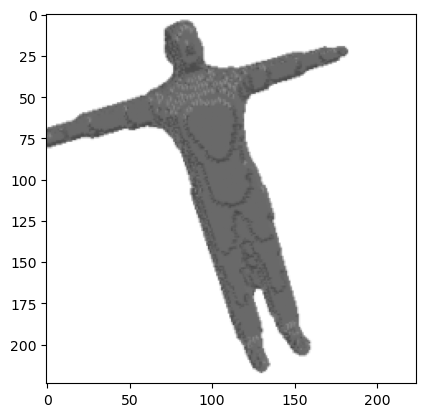

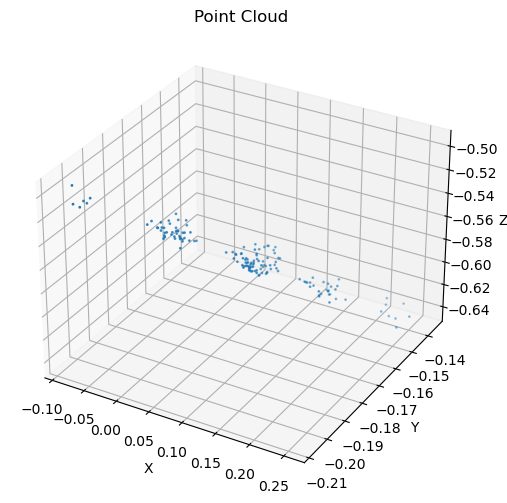

Epoch: 1
Total loss: 357.81622314453125


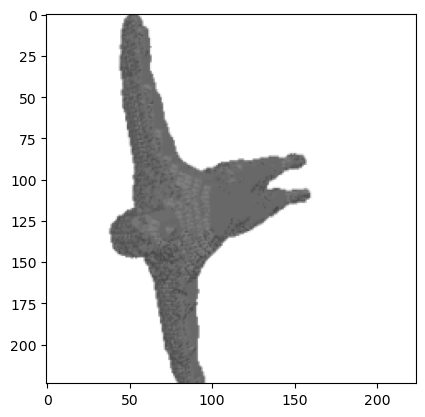

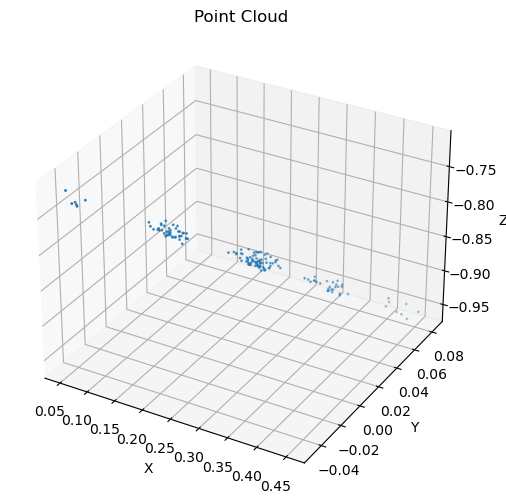

Epoch: 2
Total loss: 328.15582275390625


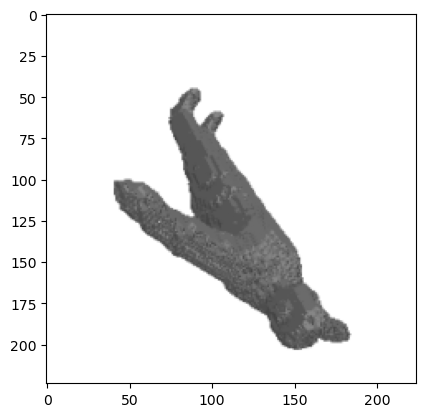

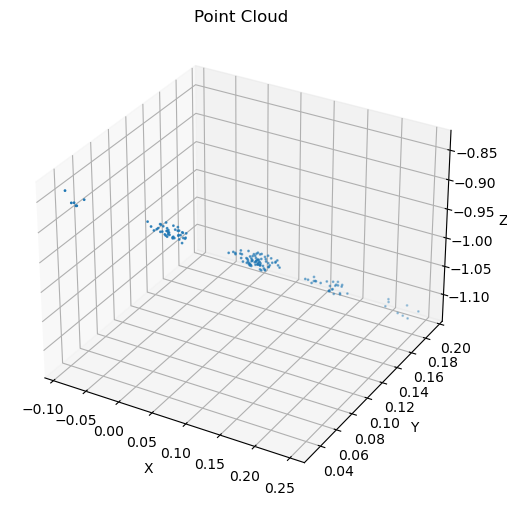

Epoch: 3
Total loss: 207.64268493652344


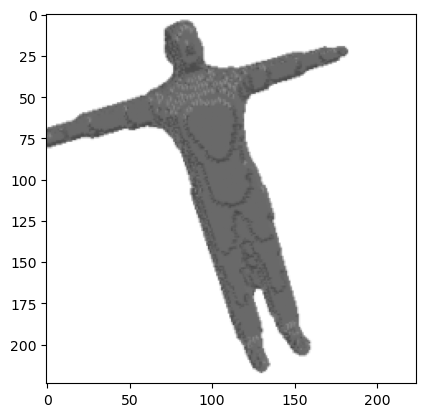

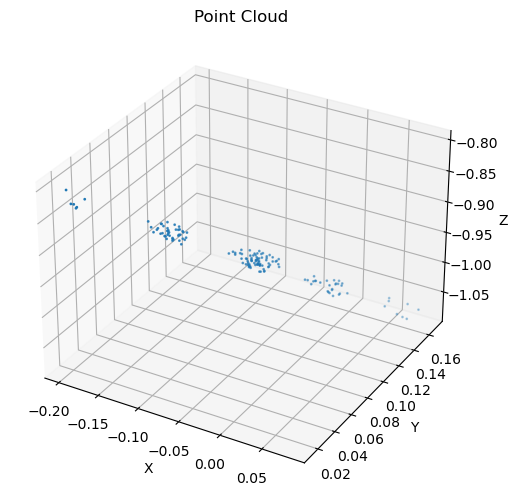

Epoch: 4
Total loss: 151.3963623046875


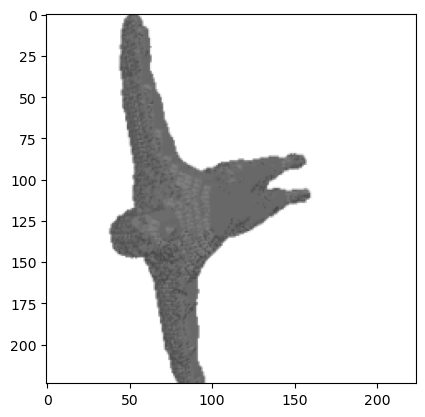

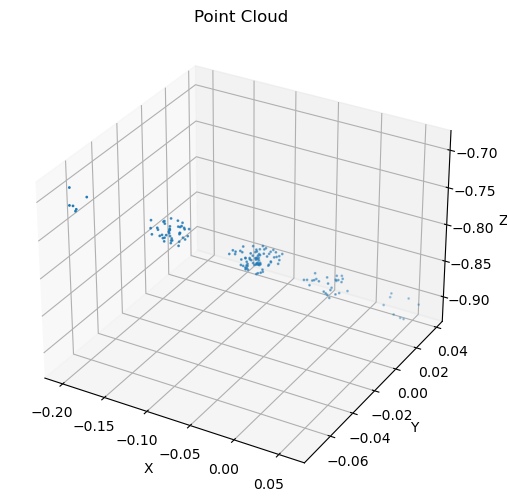

Epoch: 5
Total loss: 150.3520965576172


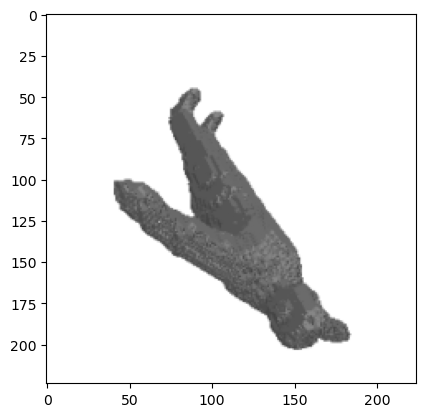

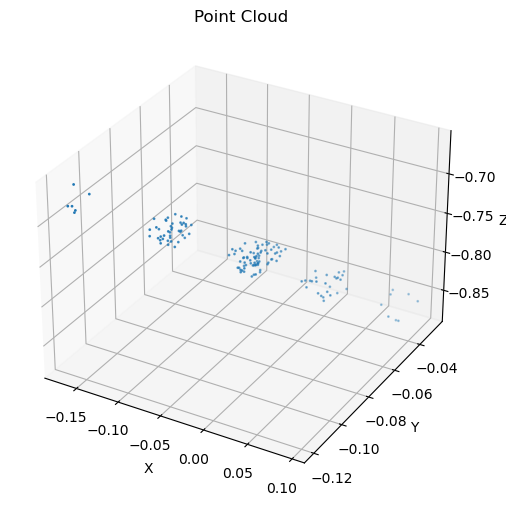

Epoch: 6
Total loss: 144.96820068359375


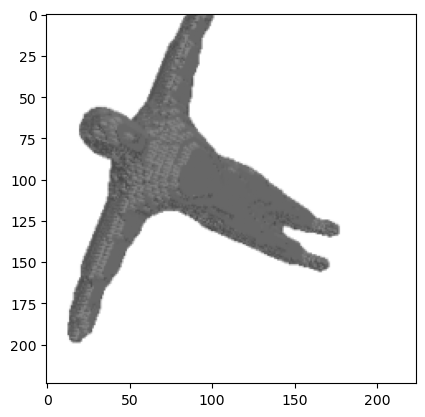

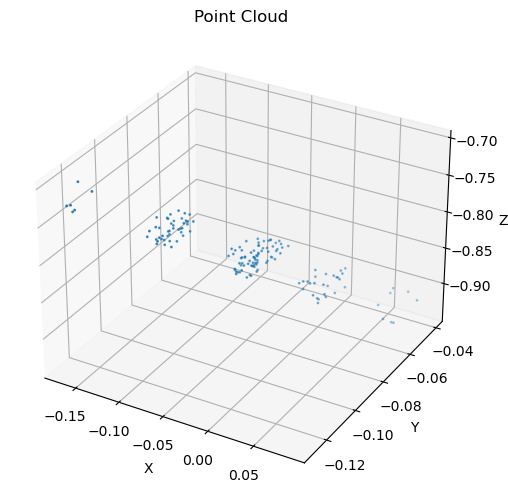

Epoch: 7
Total loss: 139.33409118652344


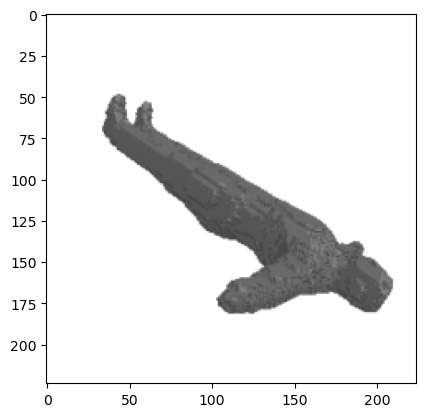

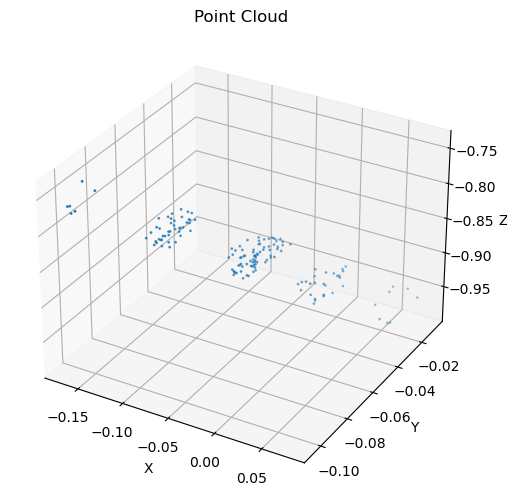

Epoch: 8
Total loss: 135.31761169433594


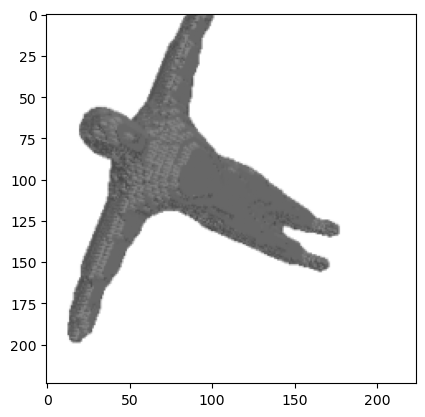

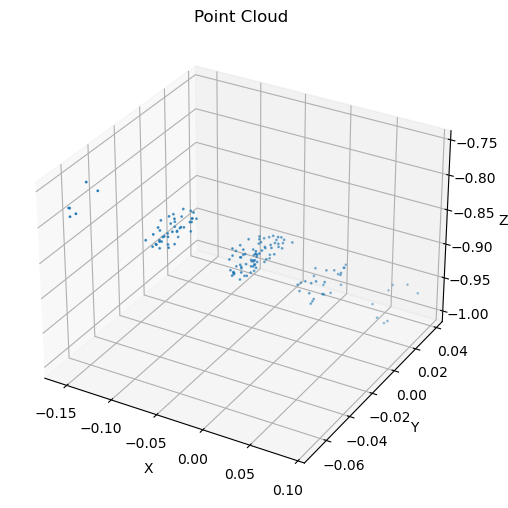

Epoch: 9
Total loss: 132.68946838378906


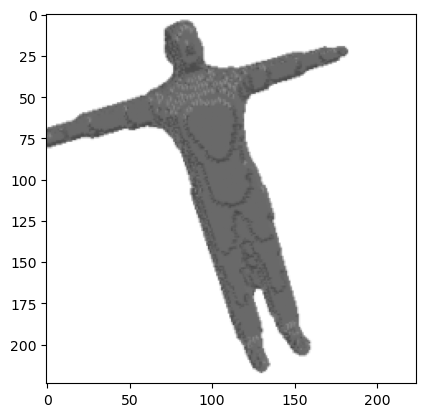

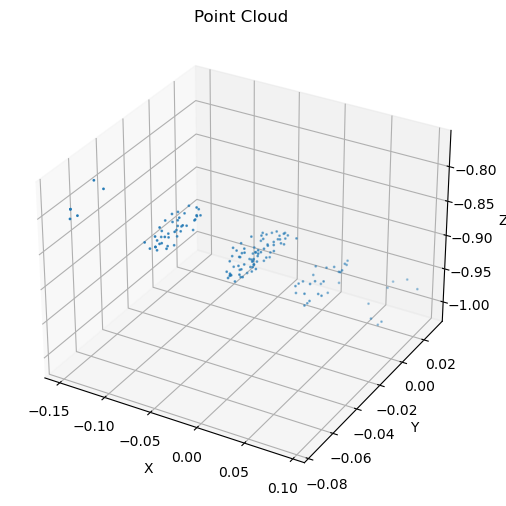

In [73]:
epochs = 10
for epoch in range(epochs):
    print(f"Epoch: {epoch}")
    total_loss = 0
    network.train()
    if epoch > 0 and epoch % 50 == 0:
        lrate = lrate / 5.
        optimizer = optim.Adam(network.parameters(), lr = lrate)
    for i, data in enumerate(train_loader, 0):
        optimizer.zero_grad()
        image,pcd = data['image'],data['pcd']
        init_pts = torch.from_numpy(ellipsoid['coord'])
        if use_cuda:
            img = img.cuda()
            pts = pts.cuda()
            normal = normal.cuda()
            init_pts = init_pts.cuda()

        pred_pts_list, pred_feats_list, pred_img = network(image, init_pcd)

        loss = total_pts_loss(pred_pts_list, pred_feats_list, init_pcd, ellipsoid, use_cuda)
        total_loss += loss
        loss.backward()
        optimizer.step()
    print(f"Total loss: {total_loss}")
    # Get a batch of training data
    dataiter = iter(train_loader)
    data = next(dataiter)

    # print(data)
    image,pcd = data['image'],data['pcd']
    init_pcd = torch.from_numpy(ellipsoid['coord'])

    pred_pts_list, pred_feats_list, pred_img = network(image, init_pcd)
    # Test run on the model
    plt.imshow(image[0].permute(1, 2, 0).numpy())
    plot_point_cloud(pred_pts_list[0].detach().numpy())
    
    

In [74]:
# Get a batch of training data
dataiter = iter(train_loader)
data = next(dataiter)

# print(data)
image,pcd = data['image'],data['pcd']
init_pcd = torch.from_numpy(ellipsoid['coord'])

pred_pts_list, pred_feats_list, pred_img = network(image, init_pcd)

my_pts_loss = total_pts_loss(pred_pts_list, pred_feats_list, init_pcd, ellipsoid, use_cuda)

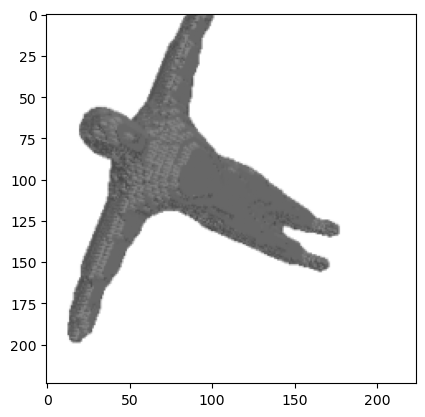

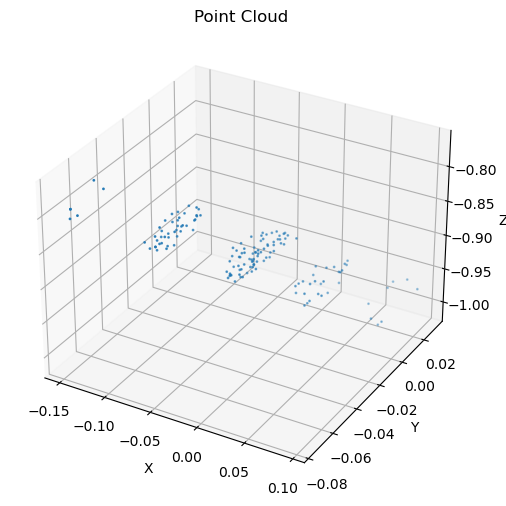

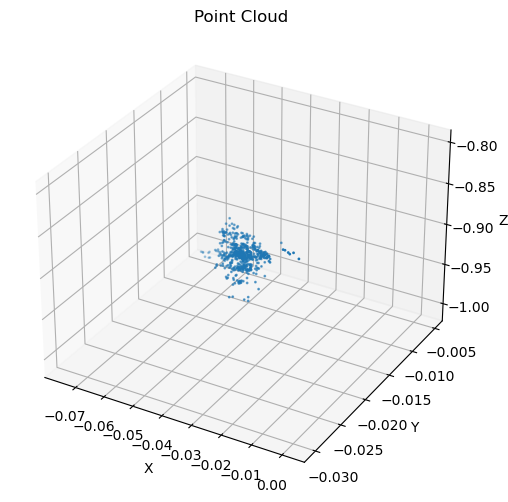

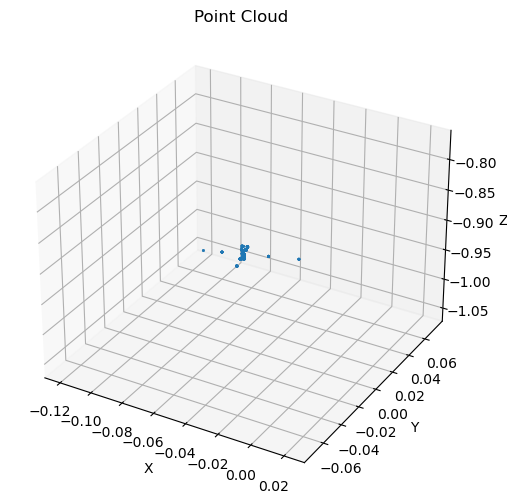

In [75]:
# Get a batch of training data
dataiter = iter(train_loader)
data = next(dataiter)

# print(data)
image,pcd = data['image'],data['pcd']
init_pcd = torch.from_numpy(ellipsoid['coord'])

pred_pts_list, pred_feats_list, pred_img = network(image, init_pcd)
# Test run on the model
plt.imshow(image[0].permute(1, 2, 0).numpy())
plot_point_cloud(pred_pts_list[0].detach().numpy())
plot_point_cloud(pred_pts_list[1].detach().numpy())
plot_point_cloud(pred_pts_list[2].detach().numpy())